# DH - Data Science - Grupo 6.

Integrantes:

*    José Roberto Canales Delgado
*    Matías Sala
*    Luciana Sande
*    Bianca Somadossi
*    Tomás Guzmán Camacho


# Desafío 1: Análisis exploratorio de un dataset de precios de propiedades.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

 Características del bien que pueden permitirnos aproximar el precio de una propiedad: 

     1) Localidad (place_with_parent_names) 
     2) Tipo de propiedad (property_type)
     3) Superficie(m2), cubierta y total (surface_total_in_m2, surface_covered_in_m2)
     4) Ambientes (rooms)

Como referencia para poder predecir precios, tomaremos los que se listan en el data set (price, currency, price_aprox_usd), 
siempre buscando agrupar los mismos por las características que detallamos previamente.

Características que van a permitirnos agregar más información sobre el bien en cuestión y su precio:

     5) Ubicación geográfica (place_with_parent_names, lat, lon, geonames_id)
     6) Amenities (properati_url, description, title)

Teniendo en cuenta que el data set contiene muchísima información y no toda estará completa o será de utilidad a nuestro entender, haremos un proceso inicial de limpieza y corrección, intentando recuperar información a partir de otras variables.

a) Estandarizar los precios a una moneda. En nuestro caso, decidimos unificar los valores en USD.

b) Completaremos datos faltantes de las columnas que consideramos relevantes, aprovechando la información descriptiva de las columnas title, descriprion y url. Para ello recurriremos a las expresiones regulares para completar las columnas de precios, superficie total (surface_total_in_m2), habitaciones (rooms) y precios por m2.

## 1. Entorno de implementación.

### 1.1 Setup inicial.

In [5]:
# initial setup
%run "common/0_notebooks_base_setup.py"

c:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


In [6]:
#importamos de todas las librerías que vamos a utilizar

import numpy as np
import pandas as pd
import re
import geopandas as gpd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import math

%matplotlib inline


Descripción de las librerías y módulos importados:

* Missingno: es una librería de Pÿthon, compatible con Pandas, que ofrece una buena y simple forma de visualizar la distribución de valores Nan (Not a Number)
* cufflinks: librería que conecta Dataframes de Pandas con Plotly, permitiendo a los usuarios crear visualizaciones directamente con Pandas

In [7]:
pd.options.display.float_format='{:,.2f}'.format

## 2. Procesamiento de los datos.


### 2.1. Importación del dataset.

In [8]:
#Importatemos el dataset original de Properatti, creando un Dataframe.

data_location = "Data/properatti.csv"

original_data = pd.read_csv(data_location, sep=",", encoding="UTF-8")


### 2.2 Exploración del dataset.

Exploramos el data set, obteniendo un primer acercamiento de sus métricas:

In [9]:
#Mostramos la composición de filas y columnas del dataset, en forma de tupla (filas,columnas).

original_data.shape


(121220, 26)

In [10]:
# A continuación, veremos cuáles son las columnas que presenta:
    
original_data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [11]:
#Mostramos los primeros 5 registros del data set:

original_data.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6618237,-58.5088387",-34.66,...,40.00,"1,127.27","1,550.00",nan,nan,nan,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,"3,432,039.00","-34.9038831,-57.9643295",-34.90,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,"3,430,787.00","-34.6522615,-58.5229825",-34.65,...,55.00,"1,309.09","1,309.09",nan,nan,nan,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,"3,431,333.00","-34.6477969,-58.5164244",-34.65,...,nan,nan,nan,nan,nan,nan,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,"3,435,548.00","-38.0026256,-57.5494468",-38.00,...,35.00,"1,828.57","1,828.57",nan,nan,nan,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [12]:
# Presentamos un resumen conciso de la estructura del dataset, incluyendo el tipo de datos de cada columna, cantidad de valores no nulos y el uso de memoria:

original_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [13]:
#Generamos estadísticas descriptivas del dataset. Las estadísticas descriptivas incluyen aquellas que resumen la
#tendencia central, la dispersión y la forma de la distribución de un conjunto de datos, excluyendo valores NaN.

original_data.describe()


,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,"121,220.00","102,503.00","69,670.00","69,670.00","100,810.00","100,810.00","100,810.00","81,892.00","101,313.00","68,617.00","87,658.00","7,899.00","47,390.00","14,262.00"
mean,"60,609.50","3,574,442.32",-34.63,-59.27,"468,525.93","4,229,396.83","239,700.58",233.80,133.05,"2,160.09","6,912.22",17.45,3.08,"5,009.23"
std,"34,993.34","354,130.62",1.98,2.30,"2,260,100.59","6,904,714.13","391,323.88","1,782.22",724.35,"2,759.29","28,378.64",120.24,1.86,"120,440.26"
min,0.00,"3,427,208.00",-54.82,-75.68,0.00,0.00,0.00,0.00,0.00,0.60,1.51,1.00,1.00,1.00
25%,"30,304.75","3,430,234.00",-34.67,-58.73,"110,000.00","1,583,309.44","89,733.88",50.00,45.00,"1,218.18","1,550.00",1.00,2.00,"1,000.00"
50%,"60,609.50","3,433,910.00",-34.60,-58.48,"185,000.00","2,558,452.50","145,000.00",84.00,75.00,"1,800.00","2,213.11",3.00,3.00,"2,000.00"
75%,"90,914.25","3,836,668.00",-34.44,-58.40,"420,000.00","4,675,792.50","265,000.00",200.00,150.00,"2,486.41","3,355.55",6.00,4.00,"4,000.00"
max,"121,219.00","6,948,895.00",4.55,-53.73,"650,000,000.00","821,271,104.30","46,545,445.00","200,000.00","187,000.00","206,333.33","3,999,999.96","3,150.00",32.00,"10,001,500.00"


#### 2.2.1. Analizamos proporción de valores NaN del dataset.

In [14]:
#Definimos una función que nos calcule el porcentaje de valores nulos para poder reutilizarla.

def get_null(df):
    missing_values_sum = df.isnull().sum()
    missing_values_percent = df.isnull().mean()*100
    return missing_values_percent


In [15]:
porcentaje_nulos = get_null(original_data)
porcentaje_nulos

Unnamed: 0                    0.00
operation                     0.00
property_type                 0.00
place_name                    0.02
place_with_parent_names       0.00
country_name                  0.00
state_name                    0.00
geonames_id                  15.44
lat-lon                      42.53
lat                          42.53
lon                          42.53
price                        16.84
currency                     16.84
price_aprox_local_currency   16.84
price_aprox_usd              16.84
surface_total_in_m2          32.44
surface_covered_in_m2        16.42
price_usd_per_m2             43.39
price_per_m2                 27.69
floor                        93.48
rooms                        60.91
expenses                     88.23
properati_url                 0.00
description                   0.00
title                         0.00
image_thumbnail               2.57
dtype: float64

<AxesSubplot:>

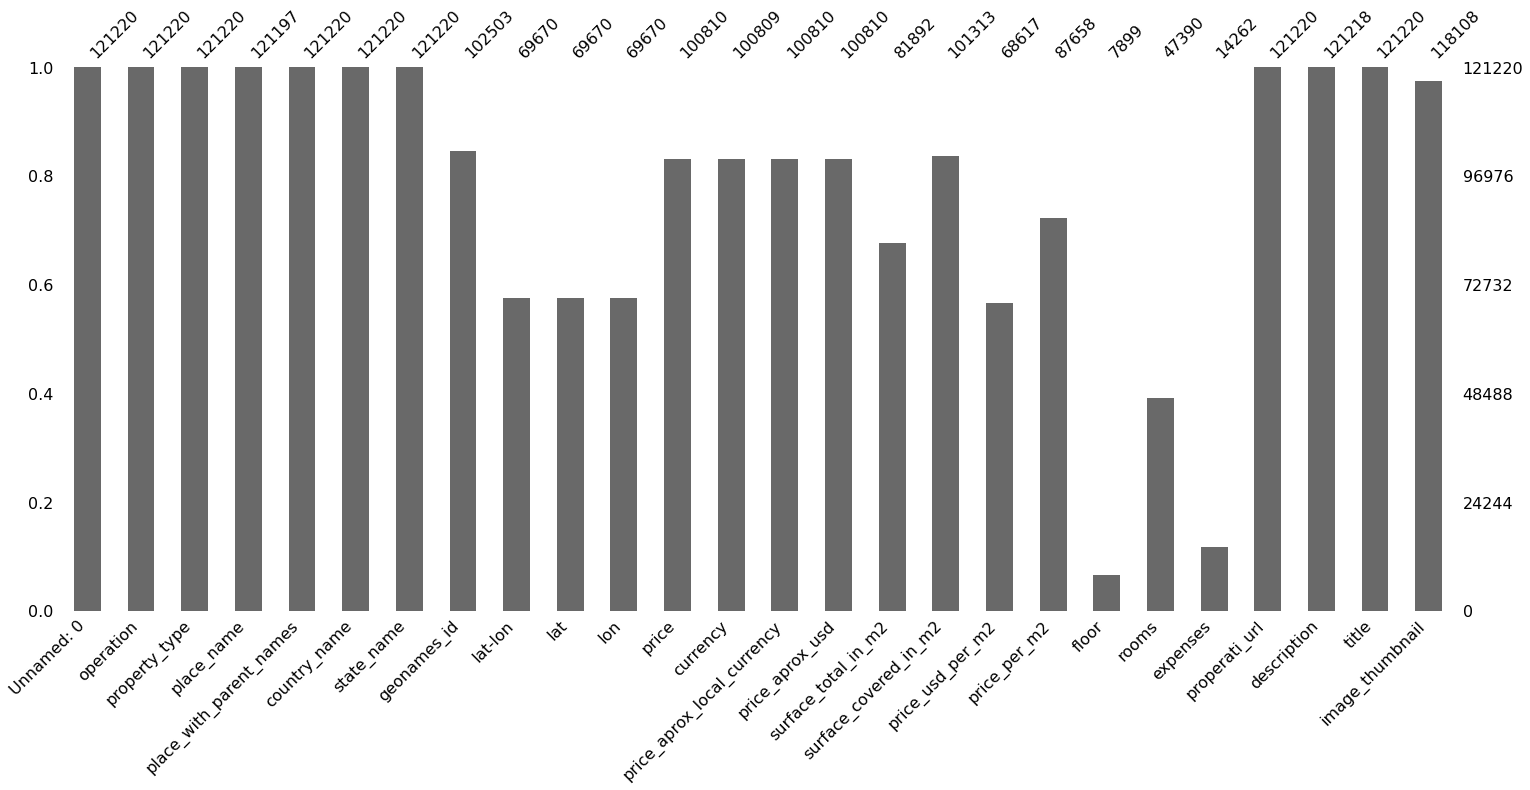

In [16]:
#Graficamos de forma comparativa la densidad de datos de cada columna, utilizando un gráfico de barras.

msno.bar(original_data)

<AxesSubplot:>

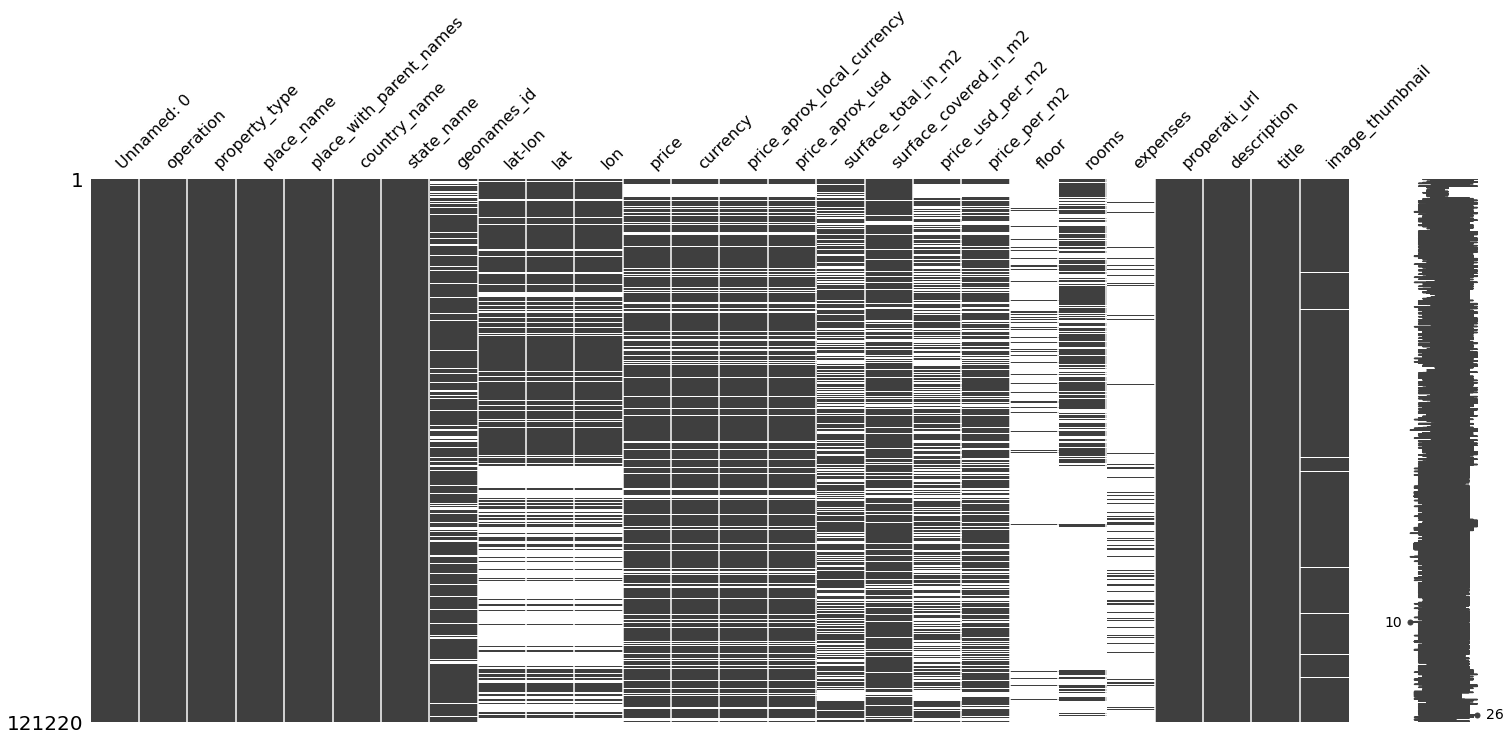

In [17]:
# Ahora aprovechamos la visualización registro a registro que nos proporciona el gráfico de matriz.

msno.matrix(original_data)

<AxesSubplot:>

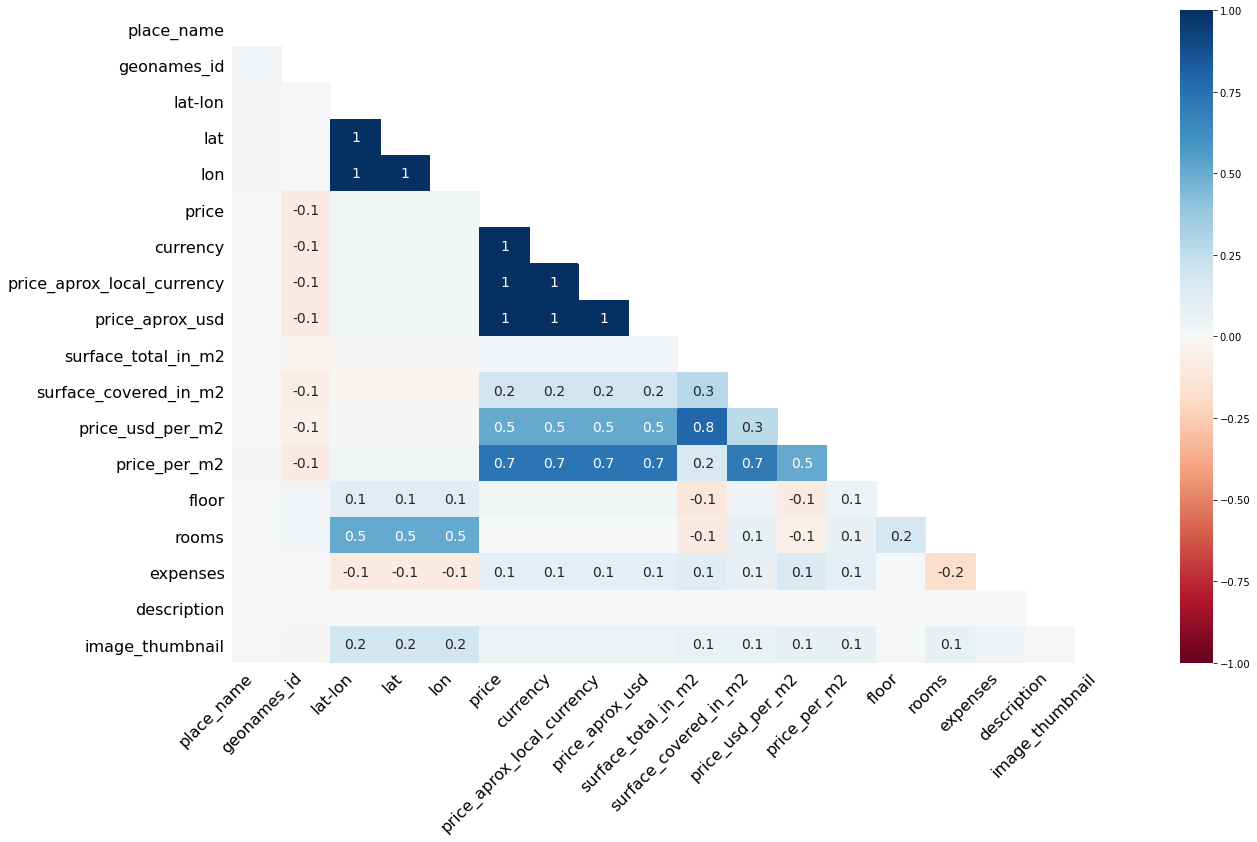

In [18]:
msno.heatmap(original_data)

## 3. Limpieza de datos.

### 3.1. Eliminación de registros por densidad de la provincia o localidad a la que corresponden.

Atento a que el datset contiene un total de 121.220 registros, analizaremos si es posible descartar, en primer lugar, aquellos que pertenezcan a
provincias o localidades que no tengan un % representativo de instancias dentro del total.
Para esto, haremos uso de la columna 'state_name'.
En primer lugar, mostraremos la densidad de cada estado.

In [19]:
dg = original_data.loc[:, ['state_name', 'lat',"lon"]]
print (dg)

                          state_name    lat    lon
0                    Capital Federal -34.66 -58.51
1             Bs.As. G.B.A. Zona Sur -34.90 -57.96
2                    Capital Federal -34.65 -58.52
3                    Capital Federal -34.65 -58.52
4       Buenos Aires Costa Atlántica -38.00 -57.55
...                              ...    ...    ...
121215               Capital Federal    nan    nan
121216      Bs.As. G.B.A. Zona Norte    nan    nan
121217               Capital Federal -34.57 -58.48
121218  Buenos Aires Costa Atlántica    nan    nan
121219               Capital Federal    nan    nan

[121220 rows x 3 columns]


In [20]:
geodg = gpd.GeoDataFrame(dg, geometry=gpd.points_from_xy(dg.lon, dg.lat))
print (geodg)

                          state_name    lat    lon  \
0                    Capital Federal -34.66 -58.51   
1             Bs.As. G.B.A. Zona Sur -34.90 -57.96   
2                    Capital Federal -34.65 -58.52   
3                    Capital Federal -34.65 -58.52   
4       Buenos Aires Costa Atlántica -38.00 -57.55   
...                              ...    ...    ...   
121215               Capital Federal    nan    nan   
121216      Bs.As. G.B.A. Zona Norte    nan    nan   
121217               Capital Federal -34.57 -58.48   
121218  Buenos Aires Costa Atlántica    nan    nan   
121219               Capital Federal    nan    nan   

                           geometry  
0       POINT (-58.50884 -34.66182)  
1       POINT (-57.96433 -34.90388)  
2       POINT (-58.52298 -34.65226)  
3       POINT (-58.51642 -34.64780)  
4       POINT (-57.54945 -38.00263)  
...                             ...  
121215              POINT (nan nan)  
121216              POINT (nan nan)  
121217  P

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geoarg = world[world.name=='Argentina']
print (geoarg)

    pop_est      continent       name iso_a3  gdp_md_est  \
9  44293293  South America  Argentina    ARG  879,400.00   

                                            geometry  
9  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...  


In [22]:
def to_chart(p_ciudad, p_pais):
    
    ax = p_pais.plot(figsize=(9,12), color='white', edgecolor='black')

    p_ciudad.plot(ax=ax, color='red', alpha= 0.4)

plt.show()

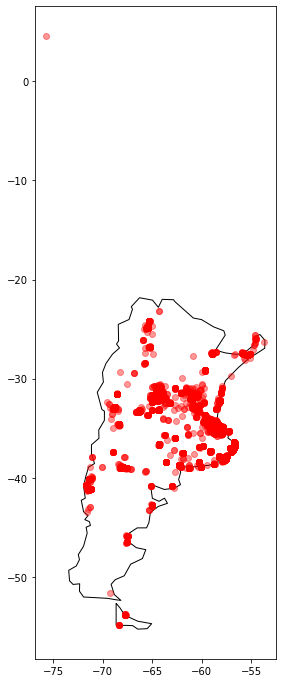

In [23]:
to_chart(geodg, geoarg)

Como podemos ver ya a partir de nuestro mapa, la mayor concentración de observaciones se encuentra en la región central del país, especialmente en Buenos Aires, Córdoba y Santa Fe.

A continuación, haremos los cálculos correspondientes para verificar si el gráfico se ajusta a la realidad de nuestro dataset y comenzar con el descarte.

In [24]:
#Mostraremos la cantidad de registros que hay de cada provincia o localidad, en una columna que llamaremos "total".

grouped_by_state = original_data.groupby("state_name").size().reset_index(name="Total")
grouped_by_state

,state_name,Total
0,Bs.As. G.B.A. Zona Norte,25560
1,Bs.As. G.B.A. Zona Oeste,9322
2,Bs.As. G.B.A. Zona Sur,13952
3,Buenos Aires Costa Atlántica,10006
4,Buenos Aires Interior,2291
5,Capital Federal,32316
6,Catamarca,27
7,Chaco,57
8,Chubut,259
9,Corrientes,583


In [25]:
#Calculamos la frecuencia en proporción al total:

data_por_state = original_data["state_name"]

proportions = 100. * data_por_state.value_counts() / len(data_por_state)
proportions

Capital Federal                26.66
Bs.As. G.B.A. Zona Norte       21.09
Bs.As. G.B.A. Zona Sur         11.51
Córdoba                         9.96
Santa Fe                        8.39
Buenos Aires Costa Atlántica    8.25
Bs.As. G.B.A. Zona Oeste        7.69
Buenos Aires Interior           1.89
Río Negro                       0.67
Neuquén                         0.60
Mendoza                         0.56
Tucumán                         0.56
Corrientes                      0.48
Misiones                        0.38
Entre Ríos                      0.30
Salta                           0.23
Chubut                          0.21
San Luis                        0.21
La Pampa                        0.13
Formosa                         0.05
Chaco                           0.05
San Juan                        0.03
Tierra Del Fuego                0.03
Catamarca                       0.02
Jujuy                           0.02
Santa Cruz                      0.02
La Rioja                        0.00
S

Teniendo en cuenta los resultado obtenidos, hemos decidido conservar únicamente aquellas provincias o localidades que representen más del 7% del total.
Es decir que eliminaremos aquellos registros que no correspondan a Capital Federal o Buenos Aires.

In [26]:
#Armaremos un nuevo dataset, aplicando el filtro recientemente descrito:

freq_mask = proportions > 7
final_states = proportions[freq_mask]

states_list = list(final_states.index)

In [27]:
states_list
print(states_list)

['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Córdoba', 'Santa Fe', 'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste']


In [28]:
mask_1 = original_data["state_name"] == 'Capital Federal'
mask_2 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Norte'
mask_3 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Sur'
mask_4 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Oes'
mask_5 = original_data["state_name"] == 'Buenos Aires Costa Atlántica'
mask_6 = original_data["state_name"] == 'Santa Fe'
mask_7 = original_data["state_name"] == 'Córdoba'

state_mask = mask_1 | mask_2 | mask_3 | mask_4 | mask_5 | mask_6 | mask_7

filtered_data = original_data[state_mask]
filtered_data.sample(5)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
74099,74099,sell,apartment,Villa Crespo,|Argentina|Capital Federal|Villa Crespo|,Argentina,Capital Federal,"3,427,458.00","-34.5955018053,-58.4436612491",-34.60,...,58.00,"2,500.00","2,586.21",nan,nan,"2,300.00",http://www.properati.com.ar/1aoj5_venta_depart...,Departamento 60m² con Carpinteria de Aluminio ...,Departamento - Villa Crespo,https://thumbs4.properati.com/3/CKJD_kO5LZE2Ge...
74767,74767,sell,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Argentina,Capital Federal,"3,427,407.00",NaN,nan,...,30.00,"2,052.63","2,600.00",nan,nan,nan,http://www.properati.com.ar/1apf1_venta_depart...,VENTA DEPARTAMENTO 1 AMBIENTE - VILLA LUROCOND...,Venta Departamento en Villa Luro,https://thumbs4.properati.com/0/dZ2JoJ_Vb0L65b...
98184,98184,sell,house,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,"3,860,259.00",NaN,nan,...,528.00,nan,nan,nan,nan,nan,http://www.properati.com.ar/1bl7d_venta_casa_c...,"- CASA DE ESTILO, EN MUY BUEN ESTADO - Planta ...",CASA DE ESTILO EN VENTA EN PLENO CENTRO DE LA ...,https://thumbs4.properati.com/4/cUUUWqWVHRs_10...
26425,26425,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"3,436,003.00",NaN,nan,...,30.00,"14,189.57","14,189.57",nan,1.00,nan,http://www.properati.com.ar/17r3a_venta_depart...,fac048- Volve tu casa un lugar especial x $ 7....,fac048- Volve tu casa un lugar especial x $ 7....,https://thumbs4.properati.com/2/HEVtG-j-HAzxD9...
114725,114725,sell,house,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,"3,860,259.00",NaN,nan,...,370.00,nan,nan,nan,9.00,nan,http://www.properati.com.ar/1caa6_venta_casa_c...,"Se vende casa en perfecto estado, equilibrada ...",CASA COUNTRY JOCKEY . 4 DORMITORIOS,NaN


In [29]:
filtered_data.shape

(104075, 26)

Como vemos a partir del .shape, nuestro nuevo dataset contiene un total de 104075 registros.

Graficaremos a continuación la distribución de densidad de nuestro dataset filtrado.

In [30]:
# Primero, volvemos a calcular las proporciones.

filtered_data_states = filtered_data["state_name"]

filtered_data_proportions = 100. * filtered_data_states.value_counts() / len(filtered_data_states)
filtered_data_proportions


Capital Federal                31.05
Bs.As. G.B.A. Zona Norte       24.56
Bs.As. G.B.A. Zona Sur         13.41
Córdoba                        11.60
Santa Fe                        9.77
Buenos Aires Costa Atlántica    9.61
Name: state_name, dtype: float64

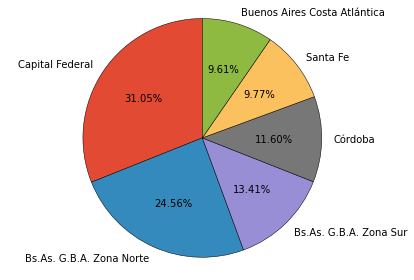

In [31]:

count=filtered_data["state_name"].value_counts().tolist()

label=filtered_data["state_name"].value_counts().index


plt.style.use('ggplot')

dic = dict(zip(label,count))

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<2500) else k):
     newdic[key] = sum([dic[i] for i in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.2f%%',wedgeprops={"edgecolor":"k"},explode=[0,0,0,0,0,0], startangle=90)
ax.axis('equal')
plt.tight_layout()

plt.show()

Tal como se desprende del gráfico, la mayor cantidad de registros pertenecen a Capital Federal y Bs. As. G.B.A. Zona Norte, siendoque el resto de las localidades representan la mitad o menos de las observaciones de las dos primeras. Por lo cual, haremos una última reducción de nuestro dataset, prescindiendo de aquellas localidades que representan menos del 20% del total. 

In [32]:
#Efectuaremos el último filtro para quedarnos únicamente con registros pertenecientes a Capital Federal y Bs. As. G.B.A. Zona Norte.

mask_1 = original_data["state_name"] == 'Capital Federal'
mask_2 = original_data["state_name"] == 'Bs.As. G.B.A. Zona Norte'

state_mask = mask_1 | mask_2

final_filtered_data = original_data[state_mask]

final_filtered_data.sample(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
492,492,sell,store,Villa de Mayo,|Argentina|Bs.As. G.B.A. Zona Norte|Malvinas A...,Argentina,Bs.As. G.B.A. Zona Norte,nan,"-34.506338,-58.670186",-34.51,...,20.00,nan,"12,500.00",nan,nan,nan,http://www.properati.com.ar/15eu1_venta_local_...,Corredor Responsable: Jorge Roca - CMCPSM 2550...,"LOCAL EN VILLA DE MAYO, IDEAL INVERSOR!!",https://thumbs4.properati.com/4/zw406dk7eFJrF9...
54217,54217,sell,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Argentina,Bs.As. G.B.A. Zona Norte,"3,427,753.00",NaN,nan,...,290.00,"2,206.90","2,206.90",nan,nan,nan,http://www.properati.com.ar/19mo0_venta_casa_t...,***LOTE LAGUNA | BARRIO ESCRITURABLE | EXCELEN...,Bustamante Propiedades | Santa Teresa en Venta,https://thumbs4.properati.com/0/QEaPi06GLyNcHR...
118159,118159,sell,house,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,"3,429,979.00",NaN,nan,...,256.00,"1,503.91","1,503.91",nan,nan,"3,000.00",http://www.properati.com.ar/1cefq_venta_casa_p...,"Casa en venta en Boulevares, desarrollada en 2...",Casa de 256 mts. en Boulevares,https://thumbs4.properati.com/4/PLouSGnOpOlWAZ...
119682,119682,sell,PH,Caballito,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,"3,435,874.00","-34.623656,-58.436944",-34.62,...,70.00,nan,"2,700.00",nan,4.00,nan,http://www.properati.com.ar/1cgzg_venta_ph_cab...,Corredor Responsable: Marcelo Trujillo - CUCIC...,"PH c/ Terraza/Parrilla en J.B.Alberdi,Total 10...",https://thumbs4.properati.com/5/2Tr7hjj-Dt-b19...
13352,13352,sell,PH,Monte Castro,|Argentina|Capital Federal|Monte Castro|,Argentina,Capital Federal,"3,430,596.00","-34.6266493741,-58.5147877344",-34.63,...,70.00,"1,365.85","1,600.00",nan,2.00,nan,http://www.properati.com.ar/16owi_venta_ph_mon...,EN VENTA TIPO DUPLEX DE 2 AMB EN 1° PISO POR E...,2 AMB FRENTE CON TERRAZA Y BALCONES SEMINUEVO ...,https://thumbs4.properati.com/1/4kkZLQpIuPhDJz...


In [33]:
dgcut = final_filtered_data.loc[:, ['state_name', 'lat',"lon"]]

In [34]:
geodgcut = gpd.GeoDataFrame(dgcut, geometry=gpd.points_from_xy(dgcut.lon, dgcut.lat))

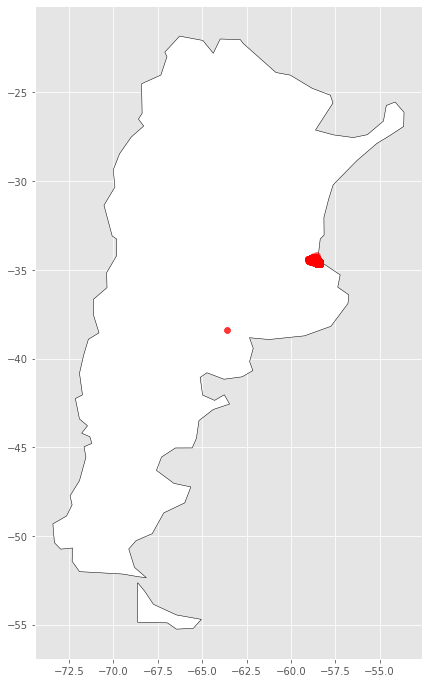

In [35]:
to_chart(geodgcut, geoarg)

In [36]:
final_filtered_data_latlon = pd.DataFrame()
final_filtered_data_latlon["localidad"] = final_filtered_data["place_with_parent_names"]
final_filtered_data_latlon["latitud"] = final_filtered_data["lat"]
final_filtered_data_latlon["longitud"] = final_filtered_data["lon"]
final_filtered_data_latlon.dropna()

,localidad,latitud,longitud
0,|Argentina|Capital Federal|Mataderos|,-34.66,-58.51
2,|Argentina|Capital Federal|Mataderos|,-34.65,-58.52
3,|Argentina|Capital Federal|Liniers|,-34.65,-58.52
6,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,-34.53,-58.52
7,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44
...,...,...,...
121153,|Argentina|Capital Federal|Barrio Norte|,-34.60,-58.40
121158,|Argentina|Capital Federal|Recoleta|,-34.59,-58.40
121160,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44
121209,|Argentina|Capital Federal|Belgrano|,-34.56,-58.44


In [37]:
BBox = ((final_filtered_data_latlon.longitud.min(),   final_filtered_data_latlon.longitud.max(),      
         final_filtered_data_latlon.latitud.min(), final_filtered_data_latlon.latitud.max()))
BBox

(-63.616672, -58.3549564938, -38.416097, -34.1598)

In [38]:
ruh_m = plt.imread("Data/map.png")

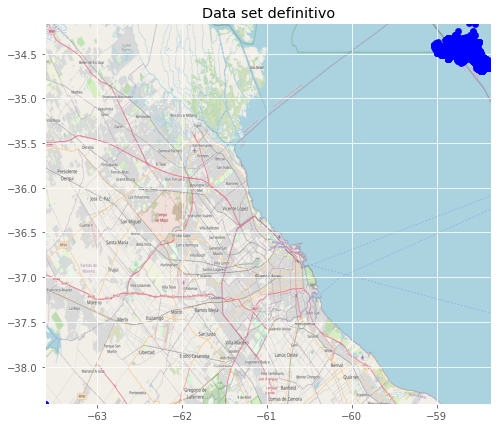

In [39]:
fig, ax = plt.subplots(figsize = (8,7))

ax.set_title('Data set definitivo')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.scatter(final_filtered_data_latlon.longitud, final_filtered_data_latlon.latitud, zorder=1, alpha= 1, c='b', s=40)
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')

# for i, txt in enumerate(final_filtered_data_latlon.localidad):
#     ax.annotate(txt, (final_filtered_data_latlon.longitud[i],final_filtered_data_latlon.latitud[i]))

### 3.2. Eliminación de registros duplicados.

In [40]:
#Calculamos el total de registros de nuestro nuevo dataset.

len(final_filtered_data)

57876

In [41]:
#Eliminamos los registros duplicados.

final_filtered_data = final_filtered_data.drop_duplicates()
len(final_filtered_data)

57876

Como vemos, el total de registros del dataset antes y después de la eliminación de duplicados es igual, por lo cual no existían duplicados.

In [42]:
# Ahora eliminaremos los registros que tengan valores duplicados en los campos descripción y precio.

final_filtered_data = final_filtered_data.drop_duplicates(subset=['price','description'])
len(final_filtered_data)

53264

En este caso podemos ver que efectivamente había registros con los mismos valores en descripción y precio, y al haberlos eliminado redujimos el dataset en poco más de cuatro mil unidades.

### 3.3. Eliminación de columnas innecesarias.

Eliminaremos columnas que creemos resultan poco útiles para cumplir el objetivo del desafío.

In [43]:
final_filtered_data.drop(['operation', 'Unnamed: 0', 'country_name', 'floor', 'expenses', 'image_thumbnail', 'lat-lon'], axis=1, inplace=True)

### 3.3.4 Normalización.

In [44]:
regex = re.compile(r'\s+')
fformat = lambda x: regex.sub(' ', str(x)).strip().lower()
final_filtered_data['description'] = final_filtered_data['description'].apply(fformat)
final_filtered_data['title'] = final_filtered_data['title'].apply(fformat)

### 3.4. Cálculo de columnas con gran porcentaje de valores NaN.

In [45]:
#Calculamos nuevamente el porcentaje de nulos de cada columna.

final_filtered_data_nulls = get_null(final_filtered_data)
final_filtered_data_nulls

property_type                 0.00
place_name                    0.04
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  19.69
lat                          39.08
lon                          39.08
price                         5.53
currency                      5.53
price_aprox_local_currency    5.53
price_aprox_usd               5.53
surface_total_in_m2          23.08
surface_covered_in_m2         6.64
price_usd_per_m2             28.07
price_per_m2                 11.42
rooms                        61.45
properati_url                 0.00
description                   0.00
title                         0.00
dtype: float64

<AxesSubplot:>

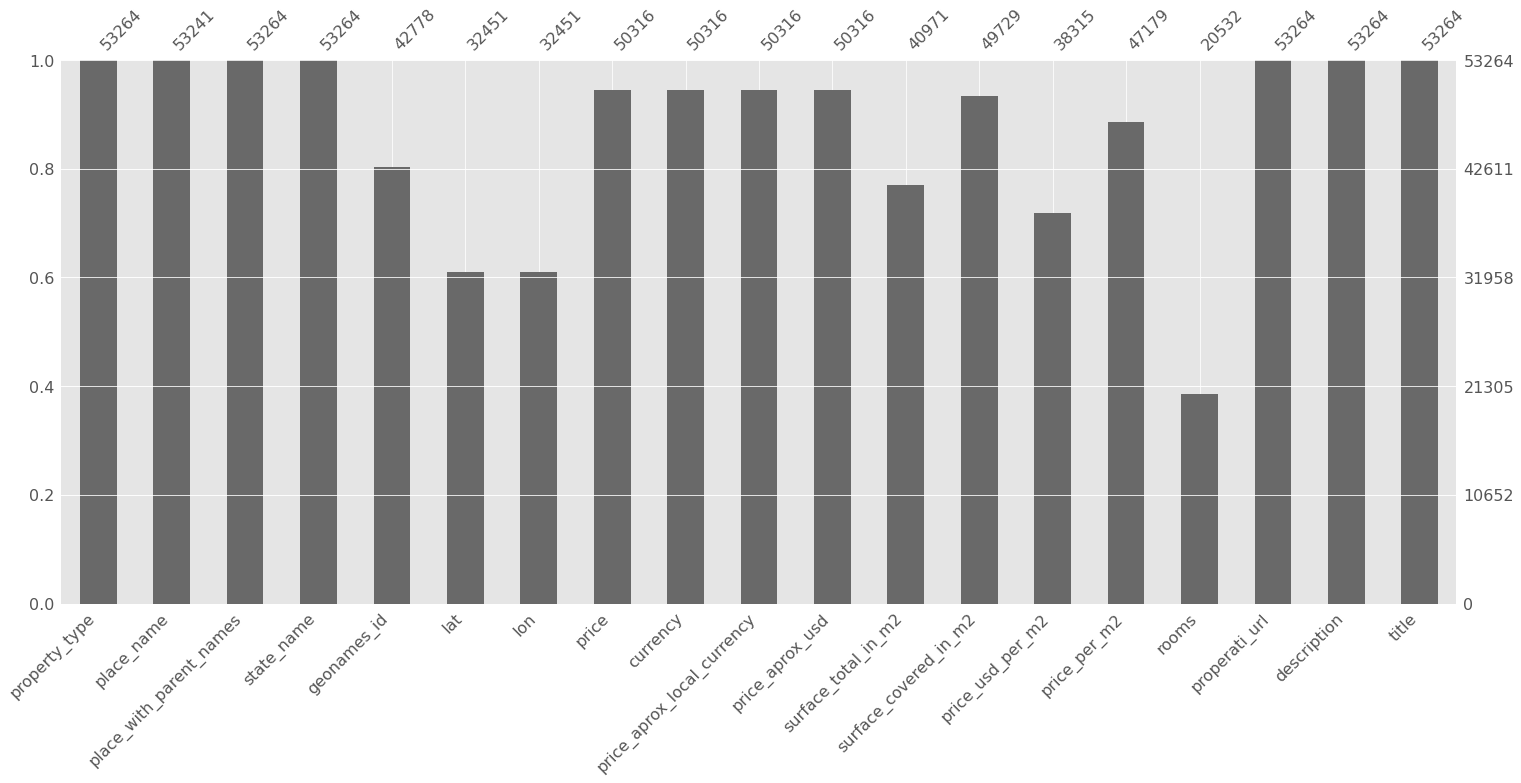

In [46]:
msno.bar(final_filtered_data)

<AxesSubplot:>

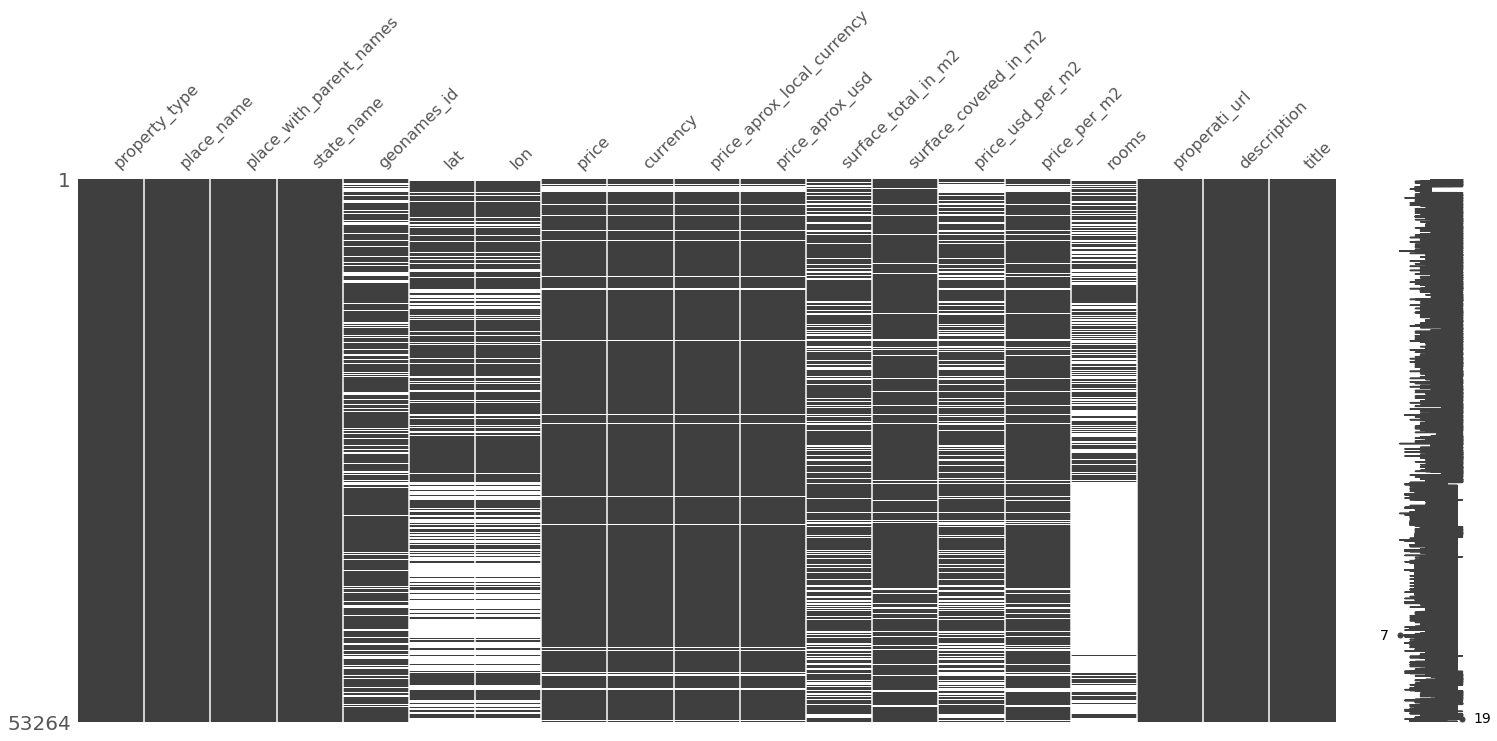

In [47]:
msno.matrix(final_filtered_data)

## 4. Imputación de valores faltantes.

### 4.1. Aproximación inicial

In [48]:
# Obtenemos los valores faltantes por columna.
final_filtered_data_missing_values = final_filtered_data.isnull().sum()

final_filtered_data_missing_values

property_type                     0
place_name                       23
place_with_parent_names           0
state_name                        0
geonames_id                   10486
lat                           20813
lon                           20813
price                          2948
currency                       2948
price_aprox_local_currency     2948
price_aprox_usd                2948
surface_total_in_m2           12293
surface_covered_in_m2          3535
price_usd_per_m2              14949
price_per_m2                   6085
rooms                         32732
properati_url                     0
description                       0
title                             0
dtype: int64

In [49]:
# Contabilizamos cuántos datos faltan en total.
total_cells = np.product(final_filtered_data.shape)
total_missing = final_filtered_data_missing_values.sum()

In [50]:
# Calculamos el porcentaje total de datos faltantes.
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

13.193566109626726


In [51]:
#Se eliminan columnas con al menos un faltante.

columns_with_na_dropped = final_filtered_data.dropna(axis=1)
columns_with_na_dropped.head()

,property_type,place_with_parent_names,state_name,properati_url,description,title
0,PH,|Argentina|Capital Federal|Mataderos|,Capital Federal,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 ambientes tipo casa planta baja por pasillo,...",2 amb tipo casa sin expensas en pb
2,apartment,|Argentina|Capital Federal|Mataderos|,Capital Federal,http://www.properati.com.ar/15bod_venta_depart...,2 ambientes 3er piso lateral living comedor am...,2 amb 3er piso con ascensor apto credito
3,PH,|Argentina|Capital Federal|Liniers|,Capital Federal,http://www.properati.com.ar/15boh_venta_ph_lin...,ph 3 ambientes con patio. hay 3 deptos en lote...,ph 3 amb. cfte. reciclado
6,PH,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,http://www.properati.com.ar/15bor_venta_ph_mun...,muy buen ph al frente con entrada independient...,"muy buen ph al frente dos dormitorios , patio,..."
7,apartment,|Argentina|Capital Federal|Belgrano|,Capital Federal,http://www.properati.com.ar/15bot_venta_depart...,excelente monoambiente a estrenar amplio super...,jose hernandez 1400 monoambiente estrenar cate...


In [52]:
# Calculamos cuanta información perdimos.

print("Columnas en el dataset original: %d \n" % final_filtered_data.shape[1])
print("Columnas con eliminación de NaN: %d" % columns_with_na_dropped.shape[1])

Columnas en el dataset original: 19 

Columnas con eliminación de NaN: 6


### 4.2. Split de columnas con información diversa.

El objetivo en este punto en analizar el tipo de información extra que brindan algunas columnas.

In [53]:
#Vamos a separar la información que contiene la columna "place_with_parent_names", ya que podemos utilizarla para completar otros campos.

s = final_filtered_data['place_with_parent_names'].str.split("|", n=4, expand=True)

In [54]:
s.head()

,0,1,2,3,4
0,,Argentina,Capital Federal,Mataderos,
2,,Argentina,Capital Federal,Mataderos,
3,,Argentina,Capital Federal,Liniers,
6,,Argentina,Bs.As. G.B.A. Zona Norte,Vicente López,Munro|
7,,Argentina,Capital Federal,Belgrano,


La columna place_with_parent_names informa acerca del país, provincia, localidad y barrio.

In [55]:
#Haremos lo mismo con la columna "properati_url", ya que la misma provee información bastante diversa.

url = final_filtered_data['properati_url'].str.split(r"\_|-", n=25, expand=True)
url.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,http://www.properati.com.ar/15bo8,venta,ph,mataderos,lavadero,patio,inmobiliaria,fedele,None,None,...,None,None,None,None,None,None,None,None,None,None
2,http://www.properati.com.ar/15bod,venta,departamentos,mataderos,lavadero,placard,inmobiliaria,fedele,None,None,...,None,None,None,None,None,None,None,None,None,None
3,http://www.properati.com.ar/15boh,venta,ph,liniers,patio,g,goffredo,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,http://www.properati.com.ar/15bor,venta,ph,munro,lavadero,patio,garage,alejandra,maradona,inmobiliaria,...,None,None,None,None,None,None,None,None,None,None
7,http://www.properati.com.ar/15bot,venta,departamentos,belgrano,lavadero,piscina,luminoso,estrenar,estilo,inmobiliario,...,None,None,None,None,None,None,None,None,None,None


La columna properati_url brinda información que utilizaremos para en apartado "amenities", como ser si la unidad tiene pileta, parrilla o quincho, entre otros.

### 4.3. Imputación de amenities.

Crearemos una columna de amenities en general, a partir de la información que podamos extraer de la columna descripción. Para ello, asumiremos que son amenities los siguientes extras: parrilla, quincho, patio, balcón, pileta y garage. Para ello haremos uso de variables "dummies". Cada amenitie contará con una columna, cuyo valor será de 1 si la unidad cuenta con ella, o 0 si no lo hace.

In [56]:
def match_pattern(text, amenity_pattern):
    if text is not np.nan:
        m = re.search(amenity_pattern, text, re.I)
        if m is not None:
            return 1
    return 0

def match_grill(value):
    return match_pattern(value, "parrilla|parrila|horno de barro|barbecue|asador")

def match_pool(value):
    return match_pattern(value, "pileta|swimming pool|piscina|picina|pisina|jacuzzi|jacuzi")

def match_barbecue(value):
    return match_pattern(value, "quincho")

def match_playground(value):
    return match_pattern(value, "patio|jardin|jardín|con parque|parque con|lindo parque|parque compartido|parque arbolado")

def match_garage(value):
    return match_pattern(value, "cochera|garage")

def match_balcony(value):
    return match_pattern(value, "balcon|balcón")

In [57]:
final_filtered_data["parrilla"] = final_filtered_data['description'].map(match_grill)
print("Total de parrilla imputados: {1}".format("parrilla", final_filtered_data["parrilla"].sum()))

final_filtered_data["quincho"] = final_filtered_data['description'].map(match_barbecue)
print("Total quincho imputados: {1}".format("quincho", final_filtered_data["quincho"].sum()))

final_filtered_data["patio"] = final_filtered_data['description'].map(match_playground)
print("Total patio imputados: {1}".format("patio", final_filtered_data["patio"].sum()))

final_filtered_data["balcon"] = final_filtered_data['description'].map(match_balcony)
print("Total balcón imputados: {1}".format("balcon", final_filtered_data["balcon"].sum()))

final_filtered_data["pileta"] = final_filtered_data['description'].map(match_pool)
print("Total pileta imputados: {1}".format("pileta", final_filtered_data["pileta"].sum()))

final_filtered_data["cochera"] = final_filtered_data['description'].map(match_garage)
print("Total cochera imputados: {1}".format("cochera", final_filtered_data["cochera"].sum()))

final_filtered_data['amenities'] = final_filtered_data['parrilla'] + final_filtered_data['quincho'] + final_filtered_data['patio'] + final_filtered_data['balcon'] + final_filtered_data['pileta'] + final_filtered_data['cochera']

Total de parrilla imputados: 21185
Total quincho imputados: 3964
Total patio imputados: 16052
Total balcón imputados: 20800
Total pileta imputados: 19432
Total cochera imputados: 22015


### 4.4. Imputación de ambientes.

Imputaremos las habitaciones faltantes, a partir de las columnas title y description.

In [58]:
final_filtered_data.rooms[~final_filtered_data.rooms.isnull()]

13       1.00
14       1.00
16       4.00
17       3.00
19       3.00
         ... 
120195   1.00
120196   1.00
120197   1.00
120198   3.00
120199   1.00
Name: rooms, Length: 20532, dtype: float64

In [59]:
#Calculo el porcenaje de nulos de la columna rooms.

final_filtered_data.rooms.isnull().sum() * 100 / len(final_filtered_data)

61.4523881045359

In [60]:
def get_rooms(value):
    """Si la celda room no está vacía, busco la expresión regular en ella"""
    if value is not np.nan:
        regex = r'([0-9]+)\s+(amb\s|amb\.|ambiente)'
        room = re.search(regex, value, re.I)
        if room is not None:
            return np.int(room.group(1))
    return np.nan

In [61]:
initial_nan_rooms = final_filtered_data["rooms"].isna().sum()
print("Total de registros rooms NaN: {0}".format(initial_nan_rooms))

final_filtered_data['rooms'].fillna(final_filtered_data['title'].map(get_rooms), inplace=True)
final_filtered_data['rooms'].fillna(final_filtered_data['description'].map(get_rooms), inplace=True)

final_nan_rooms = final_filtered_data["rooms"].isna().sum()
print("Total final de registros rooms NaN: {0}".format(final_nan_rooms))

print("Total registros rooms NaN corregidos: {0}".format(initial_nan_rooms - final_nan_rooms))


Total de registros rooms NaN: 32732
Total final de registros rooms NaN: 19505
Total registros rooms NaN corregidos: 13227


In [62]:
#Como vemos  hemos reducido al 36% la cantidad de valores NaN en esta columna.

final_filtered_data.rooms.isnull().sum() * 100 / len(final_filtered_data)

36.61948032442175

### 4.5. Imputación de Superficie cubierta.

Imputaremos la superficie cubierta en m2 faltante, a partir de la columna description.

In [63]:
def get_sup_covered_m2(value):
    """Busco y devuelvo el valor de la superficie cubierta en m2"""
    if value is not np.nan:
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+cub',
            r'sup\.\scub\s*:?\s*(\d[0-9\.,]+)',
            r'metros\s+cubiertos\s*:?(\d[0-9\.,]+)',
            r'sup\.\scubierta\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\sedificada\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+cubierta\s*:?\s*(\d[0-9\.,]+)',
        ]
        for pattern in regex:
            aux = re.search(pattern, value, re.I)
            if aux is not None:
                sup = aux.group(1).strip(',')
                sup = sup.replace('.', '').replace(',', '.')
                if sup == '':
                    return np.nan
                return np.int(float(sup))
    return np.nan

In [64]:
initial_nan_covered_sup = final_filtered_data["surface_covered_in_m2"].isna().sum()
print("Total inicial de registros de Superficie cubierta m2: {0}".format(initial_nan_covered_sup))

final_filtered_data.loc[final_filtered_data['surface_covered_in_m2'] == 1, 'surface_covered_in_m2'] = np.nan
final_filtered_data['surface_covered_in_m2'].fillna(final_filtered_data['description'].map(get_sup_covered_m2), inplace=True)

final_nan_covered_sup = final_filtered_data["surface_covered_in_m2"].isna().sum()
print("Total final de registros de Superficie cubierta m2: {0}".format(final_nan_covered_sup))

print("Total de registros de Superficie cubierta m2 corregidos: {0}".format(initial_nan_covered_sup - final_nan_covered_sup))

Total inicial de registros de Superficie cubierta m2: 3535
Total final de registros de Superficie cubierta m2: 3515
Total de registros de Superficie cubierta m2 corregidos: 20


### 4.6. Imputación de Superficie total.

Imputaremos la superficie total en m2 faltante, a partir de la columna description.

In [65]:
def get_total_sup_covered_m2(value):
    """Busco y devuelvo el valor de la superficie total en m2"""
    if value is not np.nan:
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+tot',
            r'metros\s+totales\s*:?\s*(\d[0-9\.,]+)',
            r'(\d[0-9\.,]+)\smtrs\stot',
            r'sup\.?\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'sup\.?\s+total\s+del\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+terreno\s*:?\s*(\d[0-9\.,]+)',
            r'superficie\s+total\s*:?\s*(\d[0-9\.,]+)',
            r'terreno\s*:?\s*(\d[0-9\.,]+)\s*mt',
            r'terreno\s*:?\s*(\d[0-9\.,]+),',
            r'(\d[0-9\.,]+)\s+m2\s+de\s+terreno',
            r'(\d[0-9\.,]+)\s+mts?\s+de\s+terreno',
        ]
        for pattern in regex:
            aux = re.search(pattern, value, re.I)
            if aux is not None:
                sup = aux.group(1)
                sup = sup.replace('.', '').replace(',', '.')
                return np.nan if sup == '' else np.int(float(sup))
    return np.nan

In [66]:
initial_nan_total_covered_sup = final_filtered_data["surface_total_in_m2"].isna().sum()
print("Total registros NaN de Superficie cubierta m2: {0}".format(initial_nan_total_covered_sup))

final_filtered_data['surface_total_in_m2'].fillna(final_filtered_data['description'].map(get_total_sup_covered_m2), inplace=True)

final_nan_total_covered_sup = final_filtered_data["surface_total_in_m2"].isna().sum()
print("Total final de registros NaN de Superficie Total m2: {0}".format(final_nan_total_covered_sup))
print("Total de registros NaN de Superficie total m2 corregidos: {0}".format(initial_nan_total_covered_sup - final_nan_total_covered_sup))


Total registros NaN de Superficie cubierta m2: 12293
Total final de registros NaN de Superficie Total m2: 11673
Total de registros NaN de Superficie total m2 corregidos: 620


### 4.7. Precio.

Columnas que contienen información referida a precios:
* price
* currency
* price_aprox_local_currency
* price_aprox_usd
* price_usd_per_m2
* price_per_m2

In [67]:
#Verifico los distintos tipos de moneda que contempla el dataframe.

final_filtered_data.currency.value_counts()

USD    48171
ARS     2143
PEN        2
Name: currency, dtype: int64

Como vemos, el dataframe contiene registro de precios mayormente en USD, algunos en ARS y solo dos en PEN. Nosotros trabajaremos con los precios en moneda Dólar Estadounidense.

Eliminaremos entonces regitros de monedas que no vamos a utilizar y que no son un número representativo dento del total.

In [68]:
proportions = 100. * final_filtered_data.currency.value_counts() / len(final_filtered_data)
print(proportions)

final_filtered_data.drop(final_filtered_data[final_filtered_data.currency=='PEN'].index, inplace=True)
final_filtered_data.drop(final_filtered_data[final_filtered_data.currency=='ARS'].index, inplace=True)

USD   90.44
ARS    4.02
PEN    0.00
Name: currency, dtype: float64


<AxesSubplot:>

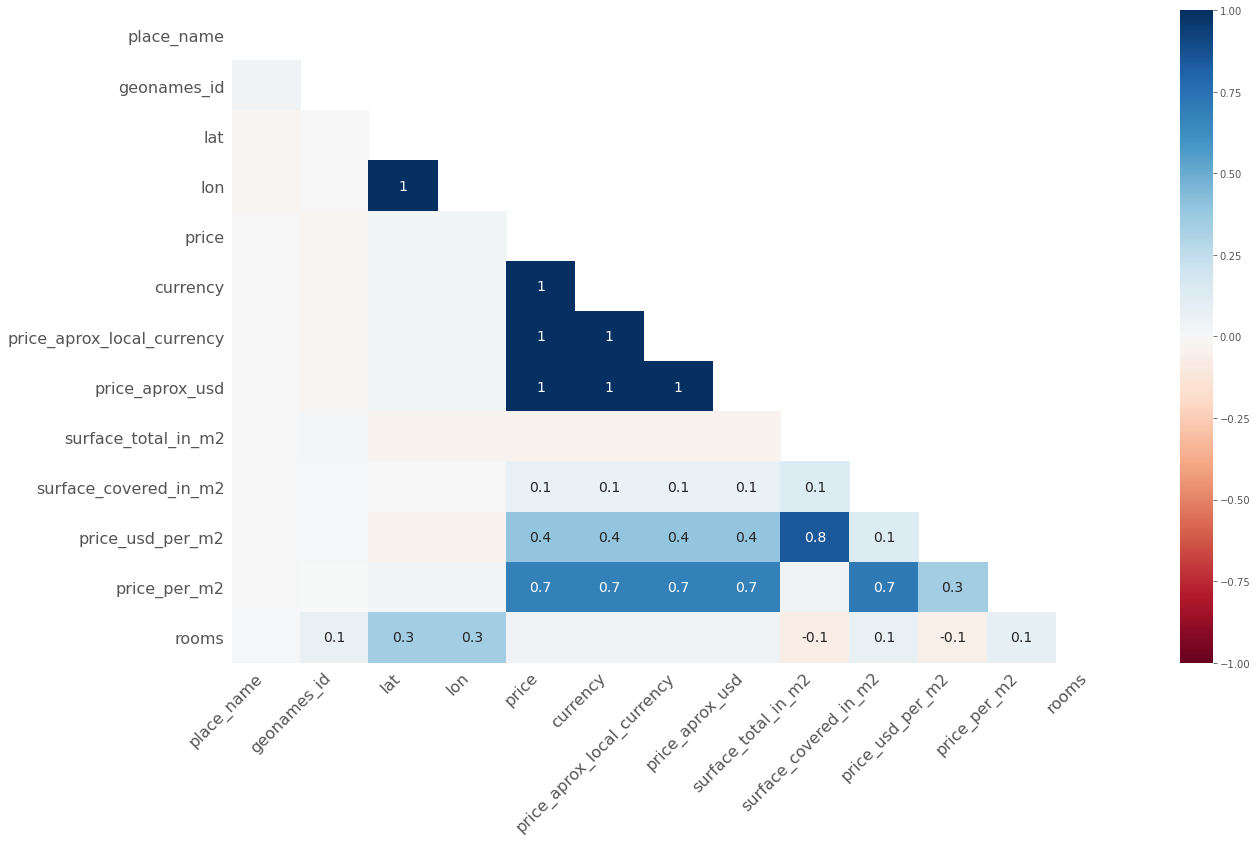

In [69]:
msno.heatmap(final_filtered_data)

In [70]:
#Verifico registros con null post imputación de valores en la columna Price y ahora sí los elimino.

print("Este es el total de regitros: {}".format(final_filtered_data.shape[0]))

total_nan_price = final_filtered_data["price_aprox_usd"].isnull().sum()
print("Este es el total de registros con Price null: {}".format(total_nan_price))

final_filtered_data = final_filtered_data[final_filtered_data['price_aprox_usd'].notna()]
print("Este es el total de registros post dprona: {}".format(final_filtered_data.shape[0]))


Este es el total de regitros: 51119
Este es el total de registros con Price null: 2948
Este es el total de registros post dprona: 48171


### 4.8. Localización (imputación de latitud y longitud).

In [71]:
#Verificaremos porcentaje de faltantes de las columnas latitud y longitud.

print("Este es el porentaje de valores nulos de la columna latitud: {}".format(final_filtered_data['lat'].isnull().sum()*100 / len(final_filtered_data)))
print("Este es el porentaje de valores nulos de la columna longitud: {}".format(final_filtered_data['lon'].isnull().sum()*100 / len(final_filtered_data)))

Este es el porentaje de valores nulos de la columna latitud: 38.42976064437109
Este es el porentaje de valores nulos de la columna longitud: 38.42976064437109


In [72]:
#Calculo cuántos valores distintos tengo en la columna place_with_parent_names que incluye provincia y barrio.

final_filtered_data.place_with_parent_names.value_counts().head(10)

|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|          2464
|Argentina|Capital Federal|Palermo|                          2316
|Argentina|Capital Federal|Belgrano|                         2305
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|                   1960
|Argentina|Capital Federal|Caballito|                        1911
|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|                   1518
|Argentina|Bs.As. G.B.A. Zona Norte|Vicente López|Olivos|    1499
|Argentina|Capital Federal|Recoleta|                         1331
|Argentina|Capital Federal|Villa Urquiza|                    1139
|Argentina|Capital Federal|Flores|                           1124
Name: place_with_parent_names, dtype: int64

Como vimos en un apartado anterior, esta columna contiene información de, al menos, tres datos distintos. Por lo tanto, procedemos a dividir su contenido.

In [73]:
#Hacemos el split de los valores que contiene la columna a partir de la pleca.

splitted_locations = final_filtered_data.place_with_parent_names.str.split('|')
splitted_locations

0               [, Argentina, Capital Federal, Mataderos, ]
2               [, Argentina, Capital Federal, Mataderos, ]
3                 [, Argentina, Capital Federal, Liniers, ]
6         [, Argentina, Bs.As. G.B.A. Zona Norte, Vicent...
7                [, Argentina, Capital Federal, Belgrano, ]
                                ...                        
121160           [, Argentina, Capital Federal, Belgrano, ]
121215           [, Argentina, Capital Federal, Belgrano, ]
121216    [, Argentina, Bs.As. G.B.A. Zona Norte, San Is...
121217      [, Argentina, Capital Federal, Villa Urquiza, ]
121219                     [, Argentina, Capital Federal, ]
Name: place_with_parent_names, Length: 48171, dtype: object

De la información que estamos mostrando, se desprende que el segundo elemento siempre es la Provincia y el tercero la localidad o el barrio. Armaremos nuevas columnas con esta información.

In [74]:
final_filtered_data['ciudad'] = splitted_locations.apply(lambda x: x[3])
final_filtered_data['barrio'] = splitted_locations.apply(lambda x: x[-2])

In [75]:
final_filtered_data.barrio.value_counts()

Tigre                          2755
Nordelta                       2464
Palermo                        2316
Belgrano                       2305
Caballito                      1911
                               ... 
Barrio Cerrado "Las Marías"       1
La Agustina                       1
coordenadas 34.255511             1
Barrio Cerrado "La Emilia"        1
El Zorzal                         1
Name: barrio, Length: 326, dtype: int64

Para poder completar las columnas de latitud y longitud, importaremos el data set de Argentina de geonames.org  (https://download.geonames.org/export/dump/AR.zip)

In [76]:
#Importamos el dataset.

arg_data = pd.read_csv('Data/AR.txt', sep="\t", header=None)

In [77]:
arg_data.set_axis(['geonames_id', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country', 'code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'dem', 'timezone', 'modification date'],axis=1, inplace=True)

In [78]:
arg_data.sample(3)

,geonames_id,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country,code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,dem,timezone,modification date
2769,3429979,Partido de Pilar,Partido de Pilar,"Partido de Pilar,Pilar",-34.42,-58.83,A,ADM2,AR,NaN,1.00,"6,638.00",nan,nan,"232,463.00",nan,12.00,America/Argentina/Buenos_Aires,2015-05-01
264,3427465,Villa Barilari,Villa Barilari,NaN,-34.70,-58.33,P,PPL,AR,NaN,1.00,"6,035.00",nan,nan,0.00,nan,7.00,America/Argentina/Buenos_Aires,2016-01-30
2114,3429320,Estancia San Alfredo,Estancia San Alfredo,NaN,-37.49,-59.44,S,RNCH,AR,NaN,1.00,"6,084.00",nan,nan,0.00,nan,248.00,America/Argentina/Buenos_Aires,2016-01-30


In [79]:
# Eliminamos las columnas no relevantes para el análisis.

arg_data.drop(['asciiname', 'alternatenames', 'feature_class', 'feature_code', 'country', 'code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'dem', 'timezone', 'modification date'],axis=1, inplace=True)

In [80]:
#chequeamos que coincidan los registros de geoname entre los datasets.

caso_1 = arg_data[arg_data['geonames_id'] == 3430234.0]
print(caso_1.loc[:,["geonames_id", "name", "latitude", "longitude"]])

caso_2 = final_filtered_data[final_filtered_data['geonames_id'] == 3430234.0].sample(1)
print(caso_2.loc[:,["geonames_id", "place_name", "lat", "lon"]])


      geonames_id     name  latitude  longitude
3024      3430234  Palermo    -34.59     -58.43
       geonames_id    place_name    lat    lon
87118 3,430,234.00  Palermo Soho -34.59 -58.42


In [81]:
#Mergeamos los dataset por "geonames_id", asumiendo entonces que coinciden estos datos en ambos.

final_filtered_data = final_filtered_data.merge(arg_data, how='left', on= 'geonames_id')
final_filtered_data.sample(3)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat,lon,price,currency,price_aprox_local_currency,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,name,latitude,longitude
2096,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,"3,428,113.00",-34.62,-58.38,"107,000.00",USD,"1,887,961.50",...,0,1,0,1,3,San Telmo,San Telmo,San Telmo,-34.62,-58.37
804,house,Barrio Santa Teresa,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Barr...,Bs.As. G.B.A. Zona Norte,nan,-34.40,-58.69,"330,000.00",USD,"5,822,685.00",...,0,1,1,0,3,Tigre,Barrio Santa Teresa,NaN,nan,nan
44626,apartment,San Nicolás,|Argentina|Capital Federal|San Nicolás|,Capital Federal,"6,693,229.00",-34.60,-58.38,"155,000.00",USD,"2,734,897.50",...,0,1,0,0,1,San Nicolás,San Nicolás,NaN,nan,nan


In [82]:
# Ahora vamos a imputar los datos faltantes de latitud y longitud, a partir de los geonames.

final_filtered_data['lat'] = final_filtered_data['lat'].fillna(final_filtered_data['latitude'])
final_filtered_data['lon'] = final_filtered_data['lon'].fillna(final_filtered_data['longitude'])

In [83]:
#Verificaremos entonces el porcentaje de nulos de ambas columnas, post imputación. Como vemos, se redujo de un 38% a un 8%.

print("Este es el porentaje de valores nulos de la columna latitud: {}".format(final_filtered_data['lat'].isnull().sum()*100 / len(final_filtered_data)))
print("Este es el porentaje de valores nulos de la columna longitud: {}".format(final_filtered_data['lon'].isnull().sum()*100 / len(final_filtered_data)))

Este es el porentaje de valores nulos de la columna latitud: 7.930082414730855
Este es el porentaje de valores nulos de la columna longitud: 7.930082414730855


In [84]:
#Eliminamos las columnas auxiliares que creamos para la operación y ya no necesitamos.

final_filtered_data.drop(['name', 'latitude', 'longitude'], axis =1, inplace=True)

In [85]:
#Calcualmos nuevamente proporciones de valores nulos en las columnas.

print(get_null(final_filtered_data))

property_type                 0.00
place_name                    0.05
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  19.73
lat                           7.93
lon                           7.93
price                         0.00
currency                      0.00
price_aprox_local_currency    0.00
price_aprox_usd               0.00
surface_total_in_m2          22.55
surface_covered_in_m2         6.25
price_usd_per_m2             24.04
price_per_m2                  6.29
rooms                        36.31
properati_url                 0.00
description                   0.00
title                         0.00
parrilla                      0.00
quincho                       0.00
patio                         0.00
balcon                        0.00
pileta                        0.00
cochera                       0.00
amenities                     0.00
ciudad                        0.00
barrio                        0.00
dtype: float64


In [86]:
# Buscamos las localidaes sin geoname, y les asignamos geoname y latitud y longitud.

aux = final_filtered_data[final_filtered_data.lat.isnull()].barrio.unique()
aux = pd.DataFrame(aux)
aux = aux.set_axis(['name'], axis=1)
#asigno lat y long a cada uno
aux_arg_data = aux.merge(arg_data, how= 'left', on= 'name')
aux_arg_data

,name,geonames_id,latitude,longitude
0,Pilar,"3,429,980.00",-34.46,-58.91
1,Pilar,"3,480,748.00",-34.44,-58.91
2,Nordelta,nan,nan,nan
3,Boulogne Sur Mer,nan,nan,nan
4,Manuel Alberti,nan,nan,nan
...,...,...,...,...
105,Villa Granaderos De San Martin,nan,nan,nan
106,Bahía del Sol,nan,nan,nan
107,Hindu Club,nan,nan,nan
108,El Viejo Vivero,nan,nan,nan


In [87]:
#Renombramos la columna name como "barrio."

aux_arg_data = aux_arg_data.rename(columns={'name' : 'barrio'})

In [88]:
#Eliminamos valores duplicados.

aux_arg_data = aux_arg_data.drop_duplicates(subset=['barrio'])

In [89]:
aux_arg_data.barrio.value_counts()

Delta               1
La Pilarica         1
Benavidez Greens    1
El Viejo Vivero     1
Fincas del Lago     1
                   ..
La Martinica        1
El Encuentro        1
La Peregrina        1
San Martín          1
Princess            1
Name: barrio, Length: 97, dtype: int64

In [90]:
# Unimos el dataframe auxiliar para asignar las ubicaciones faltantes a las localidades.

final_filtered_data = final_filtered_data.merge(aux_arg_data, how= 'left', on= 'barrio')
final_filtered_data.sample(3)

,property_type,place_name,place_with_parent_names,state_name,geonames_id_x,lat,lon,price,currency,price_aprox_local_currency,...,patio,balcon,pileta,cochera,amenities,ciudad,barrio,geonames_id_y,latitude,longitude
43007,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,nan,nan,nan,"135,000.00",USD,"2,382,007.50",...,0,0,1,1,2,Tigre,Nordelta,nan,nan,nan
44654,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Capital Federal,"3,430,234.00",-34.57,-58.42,"110,000.00",USD,"1,940,895.00",...,0,1,0,0,1,Palermo,Palermo,nan,nan,nan
27481,house,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,nan,nan,nan,"550,000.00",USD,"9,704,475.00",...,1,0,1,0,2,Tigre,Nordelta,nan,nan,nan


In [91]:
#Hacemos la imputación de los valores.

final_filtered_data['lat'] = final_filtered_data['lat'].fillna(final_filtered_data['latitude'])
final_filtered_data['lon'] = final_filtered_data['lon'].fillna(final_filtered_data['longitude'])
final_filtered_data['geonames_id_x'] = final_filtered_data['geonames_id_x'].fillna(final_filtered_data['geonames_id_y'])

In [92]:
final_filtered_data.shape

(48171, 31)

In [93]:
#Verificamos porcentaje de nulos luego de la imputacón.

print(final_filtered_data['lat'].isnull().sum()*100 / len(final_filtered_data))
print(final_filtered_data['lon'].isnull().sum()*100 / len(final_filtered_data))

6.238193103734612
6.238193103734612


In [94]:
# Comprobamos cuáles son los barrios o localidades que aun no fuern asignadas:

final_filtered_data[final_filtered_data['lat'].isnull()].ciudad.unique()

array(['Tigre', 'San Isidro', 'Pilar', 'Palermo', 'General San Martín',
       'Vicente López', 'Escobar', 'Centro / Microcentro',
       'Malvinas Argentinas', 'José C Paz', 'Balvanera',
       'Parque Avellaneda', 'San Miguel', 'Villa Santa Rita',
       'Tribunales', 'San Fernando', 'Catalinas', 'San Nicolás'],
      dtype=object)

In [95]:
#Nuevamente, eliminamos las columnas auxiliares que ya no necesitamos.

final_filtered_data.drop(['geonames_id_y', 'latitude', 'longitude'], axis =1, inplace=True)

In [96]:
#Vamos a verificar corrección de las coordenadas.

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_argentina = world[world.name=='Argentina']
geo_limpio = gpd.GeoDataFrame(final_filtered_data, geometry=gpd.points_from_xy(final_filtered_data.lon, final_filtered_data.lat))

<AxesSubplot:>

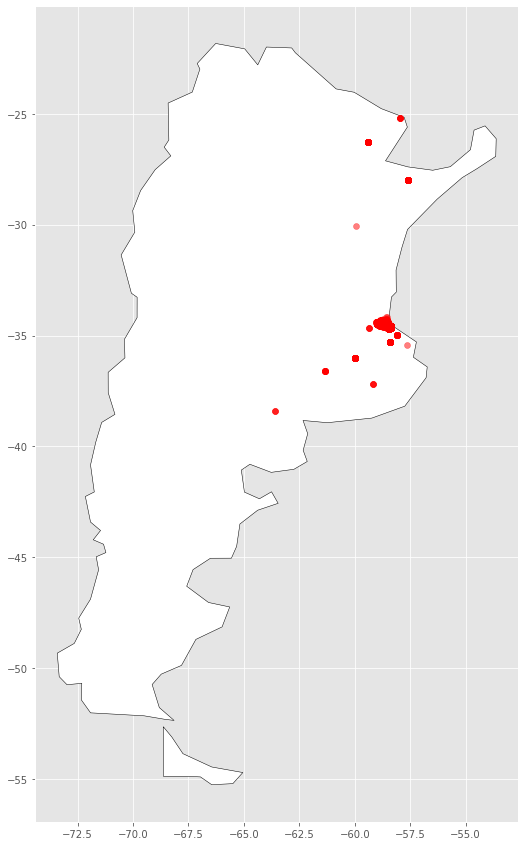

In [97]:
ax = geo_argentina.plot(figsize=(10,15), color='white', edgecolor='black')
geo_limpio.plot(ax=ax, color='red', alpha= 0.5)

In [98]:
#Renombramos la columna geonames_id_x por "geonames_id".

final_filtered_data = final_filtered_data.rename(columns={'geonames_id_x' : 'geonames_id'})

In [99]:
#resultado de la limpieza de las columnas realcionadas a la localización.

get_null(final_filtered_data.loc[:,['lat', 'lon','geometry', 'geonames_id']])

lat            6.24
lon            6.24
geometry       0.00
geonames_id   13.65
dtype: float64

### 4.8.1. Localización - distancia de estaciones de subte (Capital federal).

In [100]:
#Importamos el dataset obtenido de la web del GCBA (https://data.buenosaires.gob.ar/dataset/subte-estaciones).

underground_stations = pd.read_csv("data/estaciones-de-subte.csv", sep = ",", low_memory=False)


In [101]:
#Mostramos 5 registros de ejemplo.

underground_stations.sample(5)

,long,lat,id,estacion,linea
85,-58.40,-34.59,86.00,SANTA FE - CARLOS JAUREGUI,H
76,-58.41,-34.60,77.00,CORRIENTES,H
78,-58.41,-34.64,79.00,HOSPITALES,H
60,-58.42,-34.63,61.00,BOEDO,E
3,-58.40,-34.62,4.00,VENEZUELA,H


In [102]:
# Mostramos las columnas del dataset.

underground_stations.columns

Index(['long', 'lat', 'id', 'estacion', 'linea'], dtype='object')

In [103]:
#Seteamos el tipo ed dato de latitud y longitud.

final_filtered_data["lat"] = final_filtered_data["lat"].astype(np.float)
final_filtered_data["lon"] = final_filtered_data["lon"].astype(np.float)

In [104]:
# Definimos la función que calcule la distancia entre dos puntos (la unidad y las estaciones de subte) -nos basamos en un post de geeksforgeeks: 
# https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/

# def haversine(Olat, Olon, Dlat, Dlon):
#     """Calcula la distancia entre dos puntos"""
#     radius = 6371.  # km
#     d_lat = np.radians(Dlat - Olat)
#     d_lon = np.radians(Dlon - Olon)
#     a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
#          np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
#          np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
#     c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
#     d = radius * c
#     return d

In [105]:
def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2))
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    z = rad * c
    return z

In [106]:
def search_closest_distance(df, lat, lng):
    df['dist'] = df.apply(lambda x: haversine(x['lat'], x['long'], lat, lng), axis=1)
    return df['dist'].min()

In [107]:
def apply_distance(x):
    "Si latitud o longitud son nulos, o el registro no pertenece a Capital Federal, retorna 0; caso contrario, calcula la distancia a la estación de subte más cercana"
    if x['lat'] is np.nan:
        return 0
    if x['lon'] is np.nan:
        return 0
    if x['state_name'] != 'Capital Federal':
        return 0
    return search_closest_distance(underground_stations, x['lat'], x['lon'])


In [108]:
# Creo una columna para estación de subte más cercana, ejecutando la función creada para tal fin.

final_filtered_data['subway_distance'] = final_filtered_data.apply(apply_distance, axis=1)

In [109]:
#Aplicamos un filtro para casos de Capital Federal, para verificar que se haya completado la columna nueva.

subtes_mask = final_filtered_data['lat'].notna() & final_filtered_data['lon'].notna() & (final_filtered_data['state_name'] == 'Capital Federal')
final_filtered_data.loc[subtes_mask, ['lat', 'lon', 'subway_distance']].head()

,lat,lon,subway_distance
0,-34.66,-58.51,4.78
1,-34.65,-58.52,5.44
2,-34.65,-58.52,4.68
4,-34.56,-58.44,1.07
5,-34.56,-58.44,1.07


In [110]:
#Aplicamos un filtro para casos que no sean de Capital Federal, para verificar que no se les haya imputado valores por erorr.

nosubtes_mask = final_filtered_data['lat'].notna() & final_filtered_data['lon'].notna() & (final_filtered_data['state_name'] != 'Capital Federal')
final_filtered_data.loc[nosubtes_mask, ['lat', 'lon', 'subway_distance']].head()

,lat,lon,subway_distance
3,-34.53,-58.52,0.00
6,-34.54,-58.72,0.00
7,-34.49,-58.50,0.00
10,-34.59,-58.70,0.00
12,-34.41,-58.63,0.00


In [111]:
final_filtered_data.to_csv('./data/properati_final.csv', sep=',', index=False)

## 5. Gráficos y eliminación de outliers.

Haremos las visualizaciones generando distintos gráficos representativos de los resultados obtenidos.

In [112]:
def formula_log10(x):
  return np.log10(x) if x != 0 else x

### 5.1. Superficie.

Text(0.5, 0, 'log (Price USD)')

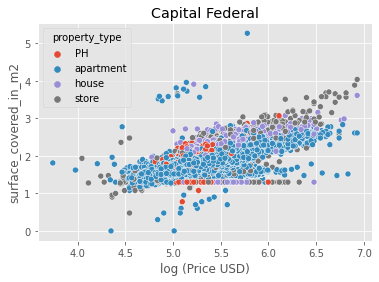

In [113]:
sns.scatterplot(x=((final_filtered_data[(final_filtered_data.state_name == 'Capital Federal')].price_aprox_usd).apply(formula_log10)), 
                y=((final_filtered_data[(final_filtered_data.state_name == 'Capital Federal')].surface_covered_in_m2).apply(formula_log10)),hue=final_filtered_data["property_type"],
                alpha=1)

final_filtered_data.drop(final_filtered_data[(final_filtered_data.surface_covered_in_m2 >20000) & (final_filtered_data.property_type == 'apartment')].index, inplace=True)
plt.title('Capital Federal')
plt.xlabel('log (Price USD)')

Text(0.5, 0, 'log (Superficie)')

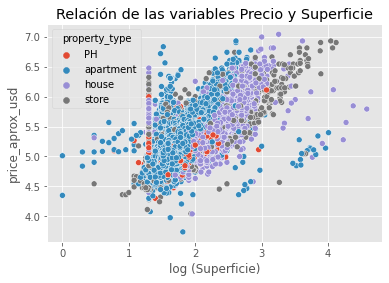

In [114]:
#existen unidades grandes baratas --> probablemente outliers
sns.scatterplot(x=final_filtered_data.surface_covered_in_m2.apply(formula_log10), 
                y=final_filtered_data.price_aprox_usd.apply(formula_log10), 
                hue=final_filtered_data.property_type)
plt.title('Relación de las variables Precio y Superficie')
plt.xlabel('log (Superficie)')

Text(0.5, 0, 'log (Price USD)')

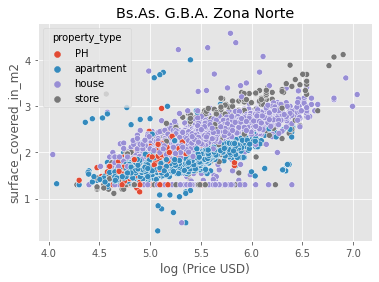

In [115]:
sns.scatterplot(x=((final_filtered_data[(final_filtered_data.state_name == 'Bs.As. G.B.A. Zona Norte')].price_aprox_usd).apply(formula_log10)), 
                y=((final_filtered_data[(final_filtered_data.state_name == 'Bs.As. G.B.A. Zona Norte')].surface_covered_in_m2).apply(formula_log10)),hue=final_filtered_data["property_type"],
                alpha=1)

final_filtered_data.drop(final_filtered_data[(final_filtered_data.surface_covered_in_m2 >1000) & (final_filtered_data.property_type == 'apartment')].index, inplace=True)
plt.title('Bs.As. G.B.A. Zona Norte')
plt.xlabel('log (Price USD)')

In [117]:
# sns.scatterplot(price,surface, s=20 ,marker="o",edgecolor="black",hue=final_filtered_data["property_type"],alpha=0.75)


In [ ]:
# final_filtered_data.drop(final_filtered_data[(final_filtered_data.surface_covered_in_m2 >500) & (final_filtered_data.property_type == 'apartment')].index, inplace=True)

In [ ]:
# final_filtered_data.drop(final_filtered_data[(final_filtered_data.surface_covered_in_m2 > 5000) & (final_filtered_data.property_type == 'store') ].index, inplace=True)

In [ ]:
# final_filtered_data.drop(final_filtered_data[final_filtered_data.surface_covered_in_m2 < 21].index, inplace=True)

## 6. Dataset final.

In [ ]:
final_filtered_data.to_csv('./data/properati_final.csv', sep=',', index=False)

In [ ]:
final_filtered_data.shape

(47248, 30)

In [ ]:
final_filtered_data.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'geonames_id', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'rooms',
       'properati_url', 'description', 'title', 'parrilla', 'quincho', 'patio',
       'balcon', 'pileta', 'cochera', 'amenities', 'ciudad', 'barrio',
       'geometry', 'subway_distance'],
      dtype='object')

In [ ]:
dataset_nulls = get_null(final_filtered_data)
dataset_nulls

property_type                 0.00
place_name                    0.05
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  13.69
lat                           6.32
lon                           6.32
price                         0.00
currency                      0.00
price_aprox_local_currency    0.00
price_aprox_usd               0.00
surface_total_in_m2          21.63
surface_covered_in_m2         6.37
price_usd_per_m2             23.05
price_per_m2                  6.40
rooms                        36.36
properati_url                 0.00
description                   0.00
title                         0.00
parrilla                      0.00
quincho                       0.00
patio                         0.00
balcon                        0.00
pileta                        0.00
cochera                       0.00
amenities                     0.00
ciudad                        0.00
barrio                        0.00
geometry            

<Figure size 720x432 with 0 Axes>

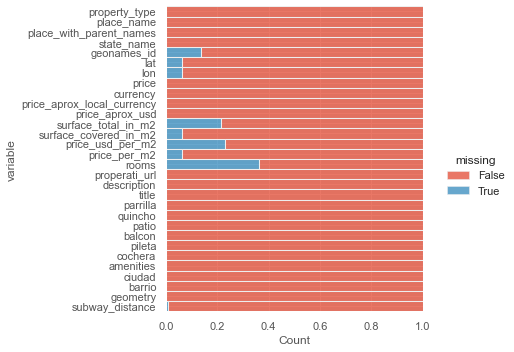

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(
    data=final_filtered_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [ ]:
final_filtered_data.dropna(inplace=True)
# final_filtered_data